In [1]:
!pip install -q git+https://github.com/MNoichl/opinionated.git#egg=opinionated

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.8/697.8 kB 6.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import opinionated

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

plt.style.use("opinions")
plt.rc('font', family='Roboto Condensed')

window_size = 7

Now downloading: Roboto Condensed
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Montserrat
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Source Code Pro
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Fira Sans
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Fira Sans Condensed
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: IBM Plex Sans
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Space Grotesk
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Space Mono
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Roboto
Font saved to: /usr/local/lib/python3.10/dist-packages/opinionated/fonts
Now downloading: Jost
Font saved to: /usr/local/lib/python3.10/dist-pa

In [3]:
path = '/content/drive/MyDrive/economics/grado economía/ML CCSS/gdp_pc_2011_prices.csv'
data = pd.read_csv(path)

data.head()

,year,ESP
0,1850,1.706
1,1851,1.720
2,1852,1.785
3,1853,1.785
4,1854,1.804


In [4]:
rel_data = data.pct_change().iloc[1:,:].reset_index(drop=True)
rel_data['year'] = data.year[1:].values
rel_data.head()

,year,ESP
0,1851,0.008206
1,1852,0.037791
2,1853,0.000000
3,1854,0.010644
4,1855,0.048780


In [5]:
def slicing_window_df(df:pd.DataFrame, window_size:int = 7, column:str ="ESP"):
    """
    Slicing window data into a dataframe in which each column is a time point
    """
    column_df = df.loc[:,column]
    data_sliced = pd.DataFrame()

    for i in range(len(column_df)-window_size):
        series = column_df.loc[i:i+window_size].reset_index(drop=True)
        series = pd.DataFrame(series).T
        data_sliced = pd.concat([data_sliced, series])

    return data_sliced.reset_index(drop=True)

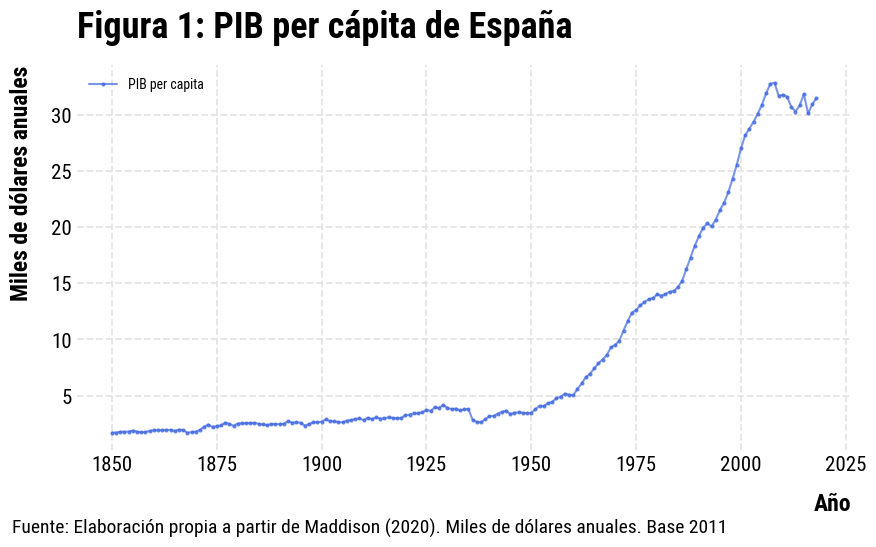

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data['year'], data['ESP'], label='PIB per capita', color='royalblue', marker='o', ms=2, alpha=0.7, markerfacecolor=None, markeredgecolor=None)

# Estableciendo el título y etiquetas de los ejes
ax.set_title('Figura 1: PIB per cápita de España')
ax.set_xlabel('Año')
ax.set_ylabel('Miles de dólares anuales')
ax.legend()

plt.figtext(0.06, -0.055, "Fuente: Elaboración propia a partir de Maddison (2020). Miles de dólares anuales. Base 2011", ha="left", fontsize=14)

plt.show()

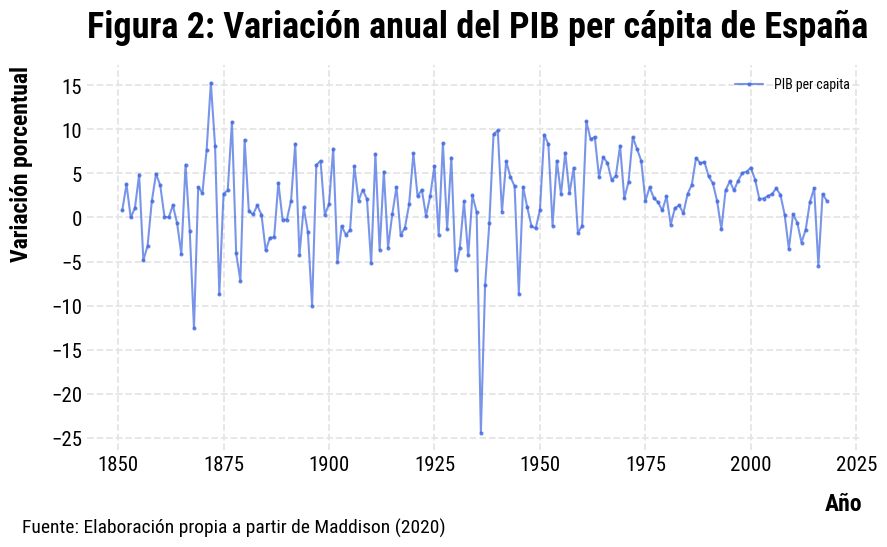

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(rel_data['year'], rel_data['ESP']*100, label='PIB per capita', color='royalblue', marker='o', ms=2, alpha=0.7, markerfacecolor=None, markeredgecolor=None)

# Estableciendo el título y etiquetas de los ejes
ax.set_title('Figura 2: Variación anual del PIB per cápita de España')
ax.set_xlabel('Año')
ax.set_ylabel('Variación porcentual')
ax.legend()

plt.figtext(0.06, -0.055, "Fuente: Elaboración propia a partir de Maddison (2020)", ha="left", fontsize=14)

plt.show()

In [8]:
df = slicing_window_df(rel_data)
print(df.shape)
df.head()

(161, 8)


,0,1,2,3,4,5,6,7
0,0.008206,0.037791,0.000000,0.010644,0.048780,-0.048626,-0.032222,0.018370
1,0.037791,0.000000,0.010644,0.048780,-0.048626,-0.032222,0.018370,0.049605
2,0.000000,0.010644,0.048780,-0.048626,-0.032222,0.018370,0.049605,0.036520
3,0.010644,0.048780,-0.048626,-0.032222,0.018370,0.049605,0.036520,0.001036
4,0.048780,-0.048626,-0.032222,0.018370,0.049605,0.036520,0.001036,0.000000


In [9]:
# Splitting the data
# We cannot split randomly the data, as we are dealing with time series
num_rows_80_percent = int(0.8 * len(df))

# Dividimos el dataframe
train_df = df.iloc[:num_rows_80_percent - window_size] # eliminamos el solape temporal
test_df = df.iloc[num_rows_80_percent:]

X_train = train_df.drop(columns=7)
y_train = train_df.loc[:,7]

X_test = test_df.drop(columns=7)
y_test = test_df.loc[:,7]

In [10]:
# Decision Tree Grid Search
tree_params = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree = DecisionTreeRegressor()  # or DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=1)
tree_grid.fit(X_train, y_train)

print(f"Best Decision Tree Parameters: {tree_grid.best_params_}")
print(f"Best Decision Tree Training Score: {tree_grid.best_score_:.3f}")

tree_best = tree_grid.best_estimator_

tree_predictions = tree_best.predict(X_train)
print(f"Decision Tree Train Score: {mean_squared_error(y_train, tree_predictions):.5f}")  # or other metric

tree_predictions = tree_best.predict(X_test)
print(f"Decision Tree Test Score: {mean_squared_error(y_test, tree_predictions):.5f}")  # or other metric

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Decision Tree Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Decision Tree Training Score: -1.524
Decision Tree Train Score: 0.00122
Decision Tree Test Score: 0.00189


In [11]:
# Random Forest Grid Search
forest_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

forest = RandomForestRegressor()  # or RandomForestClassifier()
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=1)
forest_grid.fit(X_train, y_train)

print(f"Best Random Forest Parameters: {forest_grid.best_params_}")
print(f"Best Random Forest Training Score: {forest_grid.best_score_:.3f}")

forest_best = forest_grid.best_estimator_

forest_predictions = forest_best.predict(X_train)
print(f"Random Forest Train Score: {mean_squared_error(y_train, forest_predictions):.5f}")  # or other metric

forest_predictions = forest_best.predict(X_test)
print(f"Random Forest Test Score: {mean_squared_error(y_test, forest_predictions):.5f}")  # or other metric

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}
Best Random Forest Training Score: -0.467
Random Forest Train Score: 0.00153
Random Forest Test Score: 0.00118


In [12]:
# XGBoost Grid Search
xgb_params = {
    'num_leaves': [6, 10, 40, 80, 100],
    'n_estimators': [10, 50, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [None, 5, 10, 20],
    'subsample': [0.7, 0.9, 1.0],
    'min_samples_leaf': [1, 2, 4]
}

xgb_model = xgb.XGBRegressor()  # or xgb.XGBClassifier()
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")
print(f"Best XGBoost Training Score: {xgb_grid.best_score_:.3f}")

xgb_best = xgb_grid.best_estimator_

xgb_predictions = xgb_best.predict(X_train)
print(f"XGBoost Train Score: {mean_squared_error(y_train, xgb_predictions):.5f}")  # or other metric

xgb_predictions = xgb_best.predict(X_test)
print(f"XGBoost Test Score: {mean_squared_error(y_test, xgb_predictions):.5f}")  # or other metric

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
[15:50:54] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "num_leaves" } are not used.

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50, 'num_leaves': 6, 'subsample': 0.7}
Best XGBoost Training Score: -0.421
XGBoost Train Score: 0.00023
XGBoost Test Score: 0.00124


In [13]:
lgb_params = {
    'num_leaves': [3, 6, 20, 40, 100, 400],
    'n_estimators': [50, 100, 150],
    'min_child_samples': [5, 10, 15],
    'max_depth': [-1, 5, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.03, 0.07],
    'subsample': [0.5, 0.7, 0.9, 1.0]
}

lgb_model = lgb.LGBMRegressor()  # or lgb.LGBMClassifier()
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=5, n_jobs=-1, verbose=1)
lgb_grid.fit(X_train, y_train)

print(f"Best LightGBM Parameters: {lgb_grid.best_params_}")
print(f"Best LightGBM Training Score: {lgb_grid.best_score_:.3f}")

lgb_best = lgb_grid.best_estimator_

lgb_predictions = lgb_best.predict(X_train)
print(f"LightGBM Train Score: {mean_squared_error(y_train, lgb_predictions):.5f}")

lgb_predictions = lgb_best.predict(X_test)
print(f"LightGBM Test Score: {mean_squared_error(y_test, lgb_predictions):.5f}")

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 121, number of used features: 7
[LightGBM] [Info] Start training from score 0.018615
Best LightGBM Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 5, 'n_estimators': 50, 'num_leaves': 3, 'reg_alpha': 0.07, 'subsample': 0.5}
Best LightGBM Training Score: -0.485
LightGBM Train Score: 0.00216
LightGBM Test Score: 0.00082


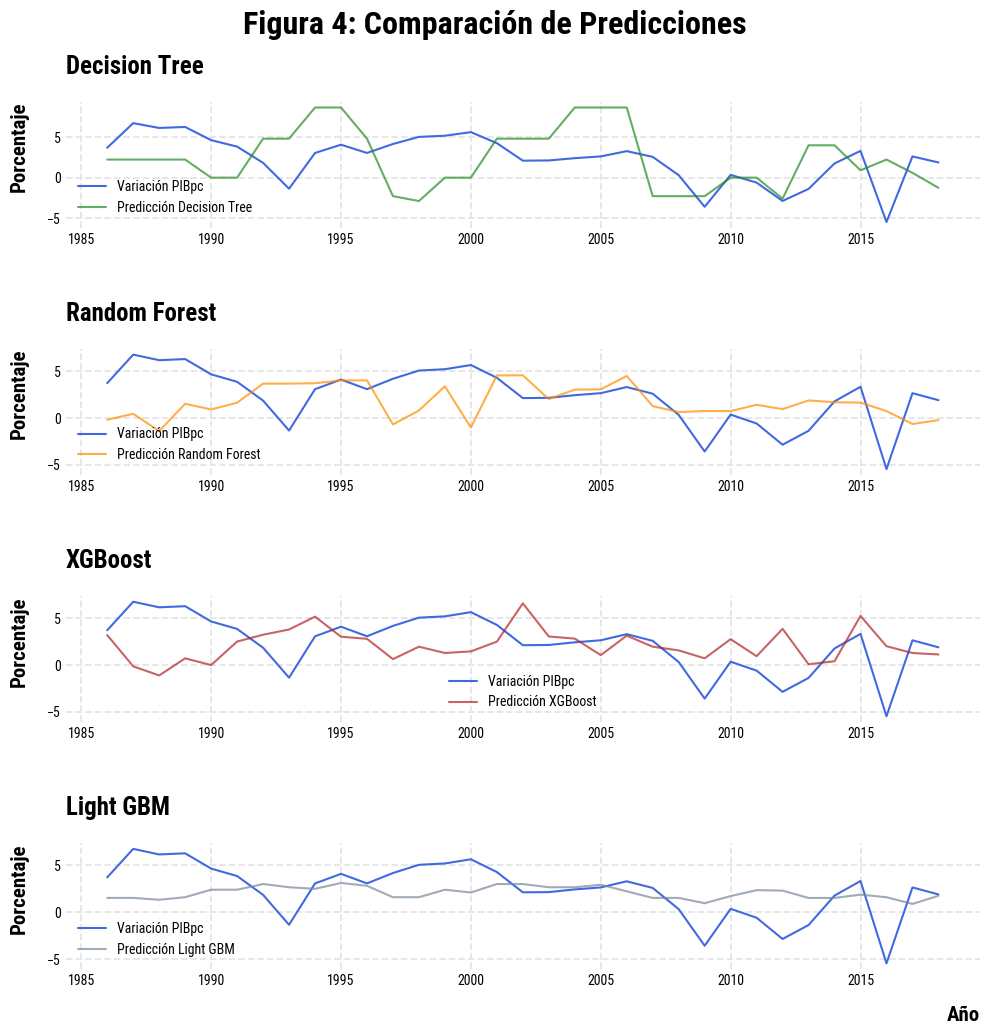

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
title_size = 18
y_label_size = 15

tick_font_size = 10

# Loop through each axis and set the tick font size
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontsize(tick_font_size)
    for label in ax.get_yticklabels():
        label.set_fontsize(tick_font_size)

# 1st subplot: Decision Tree vs. Variación PIBpc
axes[0].plot(data.year[-len(tree_predictions):], y_test*100, label='Variación PIBpc', color='royalblue')
axes[0].plot(data.year[-len(tree_predictions):], tree_predictions*100, label='Predicción Decision Tree', color='forestgreen', alpha=0.7)
axes[0].set_title('Decision Tree', fontsize=title_size)
axes[0].set_ylabel('Porcentaje', fontsize=y_label_size)
axes[0].legend()

# 2nd subplot: Random Forest vs. Variación PIBpc
axes[1].plot(data.year[-len(tree_predictions):], y_test*100, label='Variación PIBpc', color='royalblue')
axes[1].plot(data.year[-len(tree_predictions):], forest_predictions*100, label='Predicción Random Forest', color='darkorange', alpha=0.7)
axes[1].set_title('Random Forest', fontsize=title_size)
axes[1].set_ylabel('Porcentaje', fontsize=y_label_size)
axes[1].legend()

# 3rd subplot: XGBoost vs. Variación PIBpc
axes[2].plot(data.year[-len(tree_predictions):], y_test*100, label='Variación PIBpc', color='royalblue')
axes[2].plot(data.year[-len(tree_predictions):], xgb_predictions*100, label='Predicción XGBoost', color='firebrick', alpha=0.7)
axes[2].set_title('XGBoost', fontsize=title_size)
axes[2].set_ylabel('Porcentaje', fontsize=y_label_size)
axes[2].legend()

# 4th subplot: Light GBM vs. Variación PIBpc
axes[3].plot(data.year[-len(tree_predictions):], y_test*100, label='Variación PIBpc', color='royalblue')
axes[3].plot(data.year[-len(tree_predictions):], lgb_predictions*100, label='Predicción Light GBM', color='lightslategray', alpha=0.7)
axes[3].set_title('Light GBM', fontsize=title_size)
axes[3].set_xlabel('Año', fontsize=y_label_size)
axes[3].set_ylabel('Porcentaje', fontsize=y_label_size)
axes[3].legend()

plt.tight_layout(h_pad=4.0)
font_properties = {'family': 'Roboto Condensed', 'weight': 'bold'}

fig.suptitle('Figura 4: Comparación de Predicciones', **font_properties, fontsize=23, y=1.03)
plt.show()